"""
Implements an RNN on a synthetic data set, following the architecture 
described in "Deep Knowledge Tracing" by Chris Piech et al.
The RNN implementation is based on min-char-rnn.py by Andrej Karpathy (@karpathy).
BSD License
"""

In [30]:
# Python libraries
import numpy as np
import random
import sys
import csv
import matplotlib.pyplot as plt
# allows plots to show inline in ipython notebook
%matplotlib inline

# our own modules
import utils
import visualize

data_sets_map = {
    'synth':"syntheticDetailed/naive_c5_q50_s4000_v0.csv",
    'code_org' : "data/hoc_1-9_binary_input.csv"
}

DATA_SET = 'code_org'
DATA_SZ = 500000

In [31]:
# Read in the data set
# This function can be moved to utils.py
data_array = np.array(list(csv.reader(open(data_sets_map[DATA_SET],"rb"),delimiter=','))).astype('int')
# data_array = data_array[:DATA_SZ]
num_samples = data_array.shape[0]
num_problems = data_array.shape[1]

# time steps is number of problems - 1 because we cannot predict on the last problem.
num_timesteps = num_problems - 1 
# Split data into train and test (half and half)
train = data_array[0:num_samples/2,:]
test = data_array[num_samples/2:num_samples,:]

In [32]:
print (num_problems)
for prob in xrange(num_problems):
    print ('Train Prob {} : percent correct {}'.format(prob, np.mean(train[:,prob]) ))
    print ('Test Prob {} : percent correct {}'.format(prob, np.mean(test[:,prob]) ))
num_train = train.shape[0]
num_test = test.shape[0]

print ('Train : percent correct {}'.format( np.mean(train) ))

print('Vectorization...')
X_train, y_train, corr_train = utils.vectorize_syn_data(train, num_timesteps)
X_test, y_test, corr_test = utils.vectorize_syn_data(test, num_timesteps)

print ("Vectorization done!")


9
Train Prob 0 : percent correct 1.0
Test Prob 0 : percent correct 0.666894436289
Train Prob 1 : percent correct 0.953073024216
Test Prob 1 : percent correct 0.860056842287
Train Prob 2 : percent correct 0.95387272386
Test Prob 2 : percent correct 0.939857556382
Train Prob 3 : percent correct 0.940078843627
Test Prob 3 : percent correct 0.929979613367
Train Prob 4 : percent correct 0.89722170077
Test Prob 4 : percent correct 0.87799182282
Train Prob 5 : percent correct 0.883101182654
Test Prob 5 : percent correct 0.863022853303
Train Prob 6 : percent correct 0.85149615168
Test Prob 6 : percent correct 0.826338177818
Train Prob 7 : percent correct 0.680078843627
Test Prob 7 : percent correct 0.627074799794
Train Prob 8 : percent correct 0.466108503848
Test Prob 8 : percent correct 0.406046908027
Train : percent correct 0.847225663809
Vectorization...
Vectorization done!


In [34]:
# hyperparameters
hidden_size = 200 # size of hidden layer of neurons
learning_rate = 1e-1
epochs = 2
reg_strength = 0.0

# model parameters
Wxh = np.random.randn(hidden_size, num_problems * 2)*0.01 # input to hidden
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
Why = np.random.randn(num_problems, hidden_size)*0.01 # hidden to output
bh = np.zeros((hidden_size, 1)) # hidden bias
by = np.zeros((num_problems, 1)) # output bias

def lossFun(inputs, targets, correctness, hprev):
    """
    inputs,targets are both list of integers.
    hprev is Hx1 array of initial hidden state
    returns the loss, gradients on model parameters, and last hidden state
    """
    xs, hs, ys, ps, ps_denom = {}, {}, {}, {}, {}
    hs[-1] = np.copy(hprev)
    loss = 0
    # forward pass
    for t in xrange(len(inputs)):
        xs[t] = inputs[t,:].reshape((num_problems * 2, 1))
        hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
        ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
        ps_denom[t] = np.sum(np.exp(ys[t]))
        ps[t] = np.exp(ys[t]) / ps_denom[t] # probabilities for next chars

        # softmax (cross-entropy loss)
        if correctness[targets[t]] == 1:
            loss += -np.log(ps[t][targets[t],0]) 
        else:
            loss += -np.log(1-ps[t][targets[t],0]) 
        # backward pass: compute gradients going backwards
        dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
        dbh, dby = np.zeros_like(bh), np.zeros_like(by)
        dhnext = np.zeros_like(hs[0])

    for t in reversed(xrange(len(inputs))):
        dy = np.copy(ps[t])
        if correctness[targets[t]] == 1:
            dy[targets[t]] -= 1 # backprop into y
        else:
            for p in xrange(num_problems):
                if p != targets[t]:
                    dy[p] -= np.exp(ys[t][p]) / (ps_denom[t] - np.exp(ys[t][targets[t]]))



        dWhy += np.dot(dy, hs[t].T)
        dby += dy
        dh = np.dot(Why.T, dy) + dhnext # backprop into h
        dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity
        dbh += dhraw
        dWxh += np.dot(dhraw, xs[t].T)
        dWhh += np.dot(dhraw, hs[t-1].T)
        dhnext = np.dot(Whh.T, dhraw)
        for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
            np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
    grads['Wxh'] = dWxh
    grads['Whh']= dWhh
    grads['Why'] = dWhy
    grads['bh'] = dbh
    grads['by'] = dby
    grads['hnext'] = dhnext
    return loss, grads, hs[len(inputs)-1]


In [35]:
def accuracy(ps, targets, correctness):
    """
    Computes the accuracy using the predictions at each time step.
    For each t, if probability of next problem is > 0.5 for correct, or <= 0.5 
    for incorrect, then count this as correct prediction.
    """
    num_correct = 0
    for t in xrange(num_timesteps):
        predicted_prob = ps[t][targets[t],0] 
        if (predicted_prob >= 0.5 and correctness[targets[t]] == 1) or (predicted_prob < 0.5 and correctness[targets[t]] == 0):
            num_correct += 1
    accuracy = num_correct / float(num_timesteps)
    return accuracy

def forward_pass(inputs):
    xs, hs, ys, ps, ps_denom = {}, {}, {}, {}, {}
    hs[-1] = np.copy(hprev)
    for t in xrange(len(inputs)):
        xs[t] = inputs[t,:].reshape((num_problems * 2, 1))
        hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
        ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
        ps_denom[t] = np.sum(np.exp(ys[t]))
        ps[t] = np.exp(ys[t]) / ps_denom[t] # probabilities for next chars
    return ps

In [36]:
def extract_x_y_corr_for_sample(X, y, corr):
    num_timesteps = X.shape[1]
    num_problems = corr.shape[1]
    inputs = X[i,:,:].reshape((num_timesteps, num_problems * 2))
    targets = y[i,:].reshape((num_timesteps,))
    correctness = corr[i,:].reshape((num_problems))
    return inputs, targets, correctness

In [38]:

mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
smooth_loss = -np.log(1.0/num_problems)*num_timesteps # loss at iteration 0

losses = []
train_accuracies = []
test_accuracies = []
print_batch_sz = 10000
for e in xrange(epochs):
    hprev = np.zeros((hidden_size,1)) # reset RNN memory
    total_acc_train = 0.0
    total_acc_test = 0.0
    for i in xrange(num_train):
        inputs_train, targets_train, correctness_train = extract_x_y_corr_for_sample(X_train, y_train, corr_train)
        # forward num_timesteps characters through the net and fetch gradient
        loss, grads, hprev = lossFun(inputs_train, targets_train, correctness_train, hprev)
        dWxh = grads['Wxh']  
        dWhh = grads['Whh']
        dWhy = grads['Why']  
        dbh = grads['bh'] 
        dby = grads['by'] 
        smooth_loss = smooth_loss * 0.7 + loss * 0.3
        losses.append(smooth_loss)

        # perform parameter update with Adagrad
        for param, dparam, mem in zip([Wxh, Whh, Why, bh, by], 
                                      [dWxh, dWhh, dWhy, dbh, dby], 
                                      [mWxh, mWhh, mWhy, mbh, mby]):
            mem += dparam * dparam
            param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update
        ps_train = forward_pass(inputs_train)
        acc_train = accuracy(ps_train, targets_train, correctness_train)
        train_accuracies.append(acc_train)
        
        if i%print_batch_sz == 0 and i != 0:
            print ('epoch %d, iter %d, loss: %f, train acc: %f' % (e, i, smooth_loss, acc_train)) 
            
        total_acc_train += acc_train
    total_acc_train /= num_train
        
    for i in xrange(num_test):
        inputs_test, targets_test, correctness_test = extract_x_y_corr_for_sample(X_test, y_test, corr_test)
        ps_test = forward_pass(inputs_test)
        acc_test = accuracy(ps_test, targets_test, correctness_test) 
        test_accuracies.append(acc_test)
        total_acc_test += acc_test
    
    total_acc_test /= num_test
    print ('epoch %d, train acc: %f, test acc: %f' % (e, total_acc_train, total_acc_test)) # print progress
    

epoch 0, iter 10000, loss: 2.081822, train acc: 0.750000
epoch 0, iter 20000, loss: 1.930013, train acc: 0.875000
epoch 0, iter 30000, loss: 1.655611, train acc: 0.875000
epoch 0, iter 40000, loss: 2.643237, train acc: 0.875000
epoch 0, iter 50000, loss: 1.999665, train acc: 0.875000
epoch 0, iter 60000, loss: 1.389151, train acc: 1.000000
epoch 0, iter 70000, loss: 5.010376, train acc: 0.500000
epoch 0, iter 80000, loss: 1.328236, train acc: 1.000000
epoch 0, iter 90000, loss: 2.624194, train acc: 0.875000
epoch 0, iter 100000, loss: 2.762126, train acc: 0.875000
epoch 0, iter 110000, loss: 1.970932, train acc: 0.875000
epoch 0, iter 120000, loss: 1.813396, train acc: 0.875000
epoch 0, iter 130000, loss: 2.309872, train acc: 0.875000
epoch 0, iter 140000, loss: 1.103480, train acc: 1.000000
epoch 0, iter 150000, loss: 1.781091, train acc: 1.000000
epoch 0, iter 160000, loss: 1.632100, train acc: 1.000000
epoch 0, iter 170000, loss: 2.677777, train acc: 0.875000
epoch 0, iter 180000, l

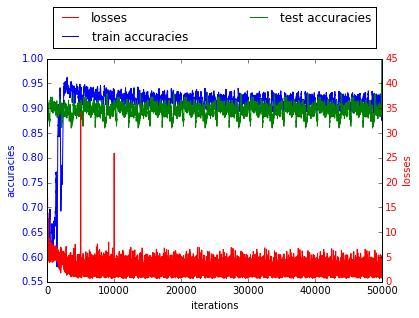

In [24]:
visualize.plot_loss_train_test_acc(losses, train_accuracies, test_accuracies, learning_rate, reg_strength, epochs, num_train)